In [1]:
import numpy as np
import matplotlib.pyplot as plt

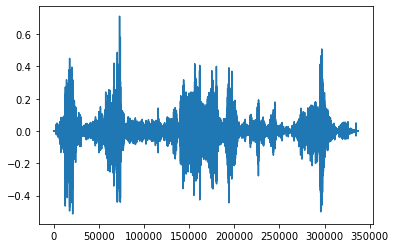

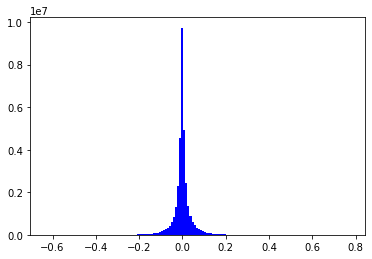

In [2]:
# 1)
import numpy as np
import matplotlib.pyplot as plt
amp_data = np.load('amp_data.npz')['amp_data']
plt.clf()
plt.plot(amp_data[::100])
plt.show()
plt.hist(amp_data, bins=150, color='b')
plt.show()

In [3]:
amp_data2 = amp_data[: -(len(amp_data) % 21)]
amp_data2 = np.reshape(amp_data2, (int(len(amp_data2) / 21), 21))
amp_data_shuffled = np.random.permutation(amp_data2)

C = amp_data2.shape[0]
X_shuf_train = amp_data_shuffled[:int(0.7*C), :20]
y_shuf_train = amp_data_shuffled[:int(0.7*C), 20]
X_shuf_val = amp_data_shuffled[int(0.7*C):int(0.85*C), :20]
y_shuf_val = amp_data_shuffled[int(0.7*C):int(0.85*C), 20]
X_shuf_test = amp_data_shuffled[int(0.85*C):, :20]
y_shuf_test = amp_data_shuffled[int(0.85*C):, 20]

In [14]:
D = 21
C = len(amp_data) // D
# The `amp_data` array is copied here to stop the in-place
# np.random.shuffle operation from changing the original data.
amp_data_re = np.reshape(amp_data.copy()[:(C*D)], (C, D))

from numpy.random import RandomState

seed = 0b00101011111010110100010011110110
random = RandomState(seed)
random.shuffle(amp_data_re)

train_end = int(len(amp_data_re) * 0.7)
val_end = train_end + int(len(amp_data_re) * 0.15)

training = amp_data_re[:train_end]
validation = amp_data_re[train_end:val_end]
test = amp_data_re[val_end:]

X_shuf_train = training[:,:D-1]
y_shuf_train = training[:,D-1:]
X_shuf_val = validation[:,:D-1]
y_shuf_val = validation[:,D-1:]
X_shuf_test = test[:,:D-1]
y_shuf_test = test[:,D-1:]

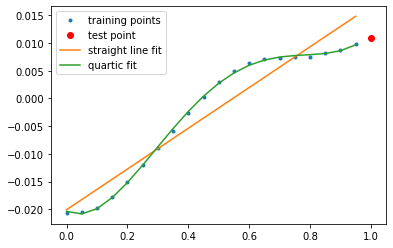

In [15]:
t_axis = np.arange(0,1,1/20)
x = X_shuf_train[0,:]
y = y_shuf_train[0]
phi = np.array([t_axis**i for i in range(5)]).T
lin_t = np.hstack((np.ones((20,1)),t_axis[:, np.newaxis]))

coef_linear = np.linalg.lstsq(lin_t, x[:, np.newaxis], rcond=None)[0]
coef_quartic = np.linalg.lstsq(phi, x[:, np.newaxis], rcond=None)[0]
x_linear = lin_t @ coef_linear
x_quartic = phi @ coef_quartic

plt.plot(t_axis, x,'.')
plt.plot([1],y, 'or')
plt.plot(t_axis, x_linear)
plt.plot(t_axis, x_quartic)
plt.legend(['training points', 'test point', 'straight line fit','quartic fit'])

plt.show()

In [16]:
def Phi(C, K):
    t = np.linspace(0.95 - ((C-1)*0.05), 0.95, C)
    phi = np.array([t**i for i in range(K)]).T
    return phi

In [17]:
def make_vv_old(C, K):
    phi = Phi(C,K)
    phi_t1 = np.ones(K)
    vv = phi_t1.T @ np.linalg.inv(phi.T @ phi) @ phi.T
    return vv

def make_vv(C, K):
    Phi2 = Phi(C, K)
    PhiTPhi_inv = np.linalg.inv(Phi2.T @ Phi2)
    v = (PhiTPhi_inv @ Phi2.T).T @ np.ones(K)[:, None]
    return v

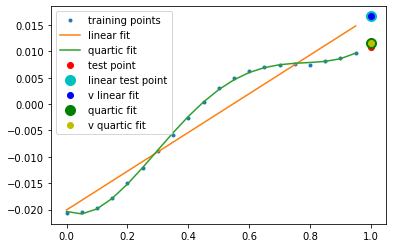

In [18]:
C = 20
K = 5
t_axis = np.arange(0,1,0.05)
x = X_shuf_train[0,:]
y = y_shuf_train[0]
phi = np.array([t_axis**i for i in range(5)]).T
lin_t = np.column_stack((np.ones(C),t_axis))

coef_linear = np.linalg.lstsq(lin_t, x[:, np.newaxis], rcond=None)[0]
coef_quartic = np.linalg.lstsq(phi, x[:, np.newaxis], rcond=None)[0]
x_linear = np.ones(2) @ coef_linear
x_quartic = np.ones(5) @ coef_quartic


vv_linear = make_vv(20,2)
vv_quartic = make_vv(20,5)
xv_linear = vv_linear.T @ x
xv_quartic = vv_quartic.T @ x


plt.plot(t_axis, x,'.')
plt.plot(t_axis, lin_t @ coef_linear)
plt.plot(t_axis, phi @ coef_quartic)
plt.plot([1],y, 'or')
plt.plot([1],x_linear, 'oc', markersize=10)
plt.plot([1], xv_linear, 'ob')
plt.plot([1],x_quartic, 'og', markersize=10)
plt.plot([1],xv_quartic, 'oy')

plt.legend(['training points', 'linear fit', 'quartic fit', 'test point',
            'linear test point', 'v linear fit','quartic fit','v quartic fit'])
plt.show()


In [21]:
Cs = np.arange(2, 21)
Ks = np.arange(2, 11)
results = {}
min_err = np.inf

for c in Cs:
    results[c] = {}
    for k in Ks:
        if c >= k:
            v = make_vv(c, k)
            y_pred = X_shuf_train[:, 20-c:] @ v
            results[c][k] = ((y_shuf_train - y_pred)**2).sum()
            if results[c][k] < min_err:
                min_err = results[c][k]
                min_err_c, min_err_k = c, k

print(f"Minimum error: {min_err}")
print(f"C: {min_err_c}")
print(f"K: {min_err_k}")

Minimum error: 15.092983429321876
C: 2
K: 2


In [20]:

Cs = np.arange(2, 21)
Ks = np.arange(2, 7)
results = {}
min_err = np.inf
min_err_c, min_err_k = 1, 1

for c in Cs:
    results[c] = dict()
    for k in Ks:
        v = make_vv(c, k)
        y_pred = v.T @ X_shuf_train[:, 20-c:].T
        y_pred_err = y_shuf_train - y_pred
        y_pred_err_sq = y_pred_err**2
        results[c][k] = y_pred_err_sq.sum()
        #results[c][k] = y_pred_err_sq.mean()
        #plt.plot(t_axis[20-c:], X_shuf_train[0, 20-c:],'bx')
        #plt.plot([1], v.T @ X_shuf_train[0, 20-c:].T,'rx')
        #plt.show()
        if results[c][k] < min_err:
            min_err = results[c][k]
            min_err_c, min_err_k = c, k

print(f"Minimum error: {min_err}")
print(f"C: {min_err_c}")
print(f"K: {min_err_k}")
for c in results:
    print(c)
    print(results[c])

MemoryError: Unable to allocate 9.19 TiB for an array with shape (1123775, 1123775) and data type float64

In [ ]:
C = [5,10,15,20,25,30,35,40]
C = np.arange(1,3)
K = [2,3,4,5,6,7,8]
results = dict()
amp_data_train = amp_data_shuffled[:int(0.7*amp_data_shuffled.shape[0]), :].flatten()
for c in C:
    results[c] = dict()
    for k in K:
        sqerr = []
        vv = make_vv(c,k)
        if -(len(amp_data_train) % (c+1)) != 0:
            amp_data2 = amp_data_train[: -(len(amp_data_train) % (c+1))]
        else:
            amp_data2 = amp_data_train
        amp_data2 = np.reshape(amp_data2, (int(len(amp_data2) / (c+1)), c+1))
        #amp_data_shuffled = np.random.permutation(amp_data2)
        for n in range(len(amp_data2)):
            x = amp_data2[n][:c]
            y = amp_data2[n][c]
            y_predicted = vv @ x
            sqerr.append((y_predicted-y)**2)
        results[c][k] = np.mean(sqerr)
minimum = np.inf
for c in results:
    for k in results[c]:
        if results[c][k] < minimum:
            bestC,bestK = c,k
            minimum =results[c][k]
print(f'Best C: {bestC}, Best K: {bestK}')

In [22]:
def mean_sq_err(X, Y, c, k):
    v = make_vv(c, k)
    y_pred = X[:, 20-c:] @ v
    y_pred_MSE = ((Y - y_pred)**2).mean()
    return y_pred_MSE
c = 2
k = 2
print(f"Train MSE: {mean_sq_err(X_shuf_train, y_shuf_train, c, k)}")
print(f"Validation MSE: {mean_sq_err(X_shuf_val, y_shuf_val, c, k)}")
print(f"Test MSE: {mean_sq_err(X_shuf_test, y_shuf_test, c, k)}")

Train MSE: 1.3430609712194946e-05
Validation MSE: 1.4324025863020012e-05
Test MSE: 1.3188748489306472e-05


In [28]:
lowest_train_mse = np.inf
lowest_val_mse = np.inf
train_mse_c = None
val_mse_c = None

for c in range(1, 21):
    result = np.linalg.lstsq(X_shuf_train[:, (20-c):], y_shuf_train, rcond=None)
    train_MSE = result[1][0] / len(X_shuf_train)
    w = result[0]
    y_val_pred = X_shuf_val[:, (20-c):] @ w
    val_MSE = ((y_shuf_val - y_val_pred)**2).mean()
    if train_MSE < lowest_train_mse:
        lowest_train_mse = train_MSE
        train_mse_c = c
    if val_MSE < lowest_val_mse:
        lowest_val_mse = val_MSE
        val_mse_c = c
print(f"C witch lowest train MSE: {train_mse_c}")
print(f"C witch lowest validation MSE: {val_mse_c}")

C witch lowest train MSE: 20
C witch lowest validation MSE: 18


In [30]:
# Linear
c1 = 18
w_lin = np.linalg.lstsq(X_shuf_train[:, 20-c1:], y_shuf_train, rcond=None)[0]
y_pred_lin = (X_shuf_test[:, 20-c1:] @ w_lin)
lin_MSE = ((y_shuf_test - y_pred_lin)**2).mean()

# Polynomial
c2 = 2
k = 2
v = make_vv(c2, k)
y_pred_pol = X_shuf_test[:, 20-c2:] @ v
pol_MSE = ((y_shuf_test- y_pred_pol)**2).mean()

print(f"Linear MSE: {lin_MSE} Polynomial MSE: {pol_MSE}")

Linear MSE: 7.518771084991879e-06 Polynomial MSE: 1.3188748489306472e-05


In [ ]:
C = 5
K = 2

# amp_data2 = amp_data[: -(len(amp_data) % 21)]
# amp_data2 = np.reshape(amp_data2, (int(len(amp_data2) / 21), 21))
# amp_data_shuffled = np.random.permutation(amp_data2)

L = amp_data_shuffled.shape[0]

amp_data_train = amp_data_shuffled[:int(0.7*L), :].flatten()
amp_data_val = amp_data_shuffled[int(0.7*L):int(0.85*L), :].flatten()
amp_data_test = amp_data_shuffled[int(0.85*L):, :].flatten()

amp_data_train = amp_data_train[: -(len(amp_data_train) % (C+1))]
amp_data_val = amp_data_val[: -(len(amp_data_val) % (C+1))]
#amp_data_test = amp_data_test[: -(len(amp_data_test) % (C+1))]

amp_data_train = np.reshape(amp_data_train, (int(len(amp_data_train) / (C+1)), C+1))
amp_data_val = np.reshape(amp_data_val, (int(len(amp_data_val) / (C+1)), C+1))
amp_data_test = np.reshape(amp_data_test, (int(len(amp_data_test) / (C+1)), C+1))

train_mse = []
val_mse = []
test_mse = []

vv = make_vv(C,K)

for n in range(len(amp_data_train)):
    x = amp_data_train[n][:C]
    y = amp_data_train[n][C]
    y_predicted = vv @ x
    train_mse.append((y_predicted-y)**2)
train_mse = np.mean(train_mse)

for n in range(len(amp_data_val)):
    x = amp_data_val[n][:C]
    y = amp_data_val[n][C]
    y_predicted = vv @ x
    val_mse.append((y_predicted-y)**2)
val_mse = np.mean(val_mse)

for n in range(len(amp_data_test)):
    x = amp_data_test[n][:C]
    y = amp_data_test[n][C]
    y_predicted = vv @ x
    test_mse.append((y_predicted-y)**2)
test_mse = np.mean(test_mse)

print(f'Train MSE: {train_mse}\n',
      f'Val MSE: {val_mse}\n'
      f'Test MSE: {test_mse}\n')

In [ ]:
C = np.arange(1,21)
train_mse = dict()
val_mse = dict()
results = dict()
for c in C:
        train_mse[c] = np.linalg.lstsq(X_shuf_train[:,-c:], y_shuf_train)[1][0]/len(y_shuf_train)
        val_mse[c] = np.linalg.lstsq(X_shuf_val[:,-c:], y_shuf_val)[1][0]/len(y_shuf_val)
print('Train MSE: ', min(train_mse, key = train_mse.get))
print('Val MSE: ', min(val_mse, key = val_mse.get))

In [ ]:
C1 = 20
C2 = 5
K = 2
linear_mse = np.linalg.lstsq(X_shuf_test[:,-C1:], y_shuf_test)[1][0]/len(y_shuf_test)

vv = make_vv(C2,K)
y_predicted = X_shuf_test[:,-C2:] @ vv
polynomial_mse = np.mean((y_predicted-y_shuf_test)**2)
print('Linear MSE: ', linear_mse)
print('Polynomial MSE: ', polynomial_mse)

In [ ]:
C1 = 20
y_predicted = X_shuf_val[:,-C1:] @ np.linalg.lstsq(X_shuf_val[:,-C1:], y_shuf_val)[0]
val_mse = (y_shuf_val - y_predicted)


plt.hist(amp_data, bins=150, color='b')
plt.show()
plt.hist(val_mse, bins=150, color='r')
plt.show()

In [ ]:

make_vv(5,2)

In [ ]:
Phi(10,3)

In [ ]:
X = np.arange(0, 1, 0.05)
X_21 = np.arange(0, 1.05, 0.05)
plt.plot(X, X_shuf_train[0], '.')
plt.xticks(np.arange(0, 1.1, 0.1))

a = np.column_stack((np.ones(20), X))
w = np.linalg.lstsq(a, X_shuf_train[0], rcond=None)[0]

b = np.column_stack((np.ones(21), X_21))
Y_str = b @ w
plt.plot(X_21, Y_str)

c = np.column_stack((np.ones(20), X, X**2, X**3, X**4))
w_pol = np.linalg.lstsq(c, X_shuf_train[0], rcond=None)[0]

d = np.column_stack((np.ones(21), X_21, X_21**2, X_21**3, X_21**4))
Y_pol = d @ w_pol
plt.plot(1.0, Y_pol[20], 'rx')
plt.plot(X_21, Y_pol)

plt.show()

In [ ]:

t_axis = np.arange(0,1,1/20)
x = X_shuf_train[1,:]
y = y_shuf_train[1]
phi = np.array([t_axis**i for i in range(5)]).T
lin_t = np.hstack((np.ones((20,1)),t_axis[:, np.newaxis]))

coef_linear = np.linalg.lstsq(lin_t, x[:, np.newaxis], rcond=None)[0]
coef_quartic = np.linalg.lstsq(phi, x[:, np.newaxis], rcond=None)[0]
x_linear = lin_t @ coef_linear
x_quartic = phi @ coef_quartic

plt.plot(t_axis, x,'.')
plt.plot([1],y_shuf_train[0], 'or')
plt.plot(t_axis, x_linear)
plt.plot(t_axis, x_quartic)
plt.legend(['training points', 'test point', 'straight line fit','quartic fit'])

plt.show()

In [ ]:

def make_vv(C, K):
    Phi2 = Phi(C, K)
    PhiTPhi_inv = np.linalg.inv(Phi2.T @ Phi2)
    return (PhiTPhi_inv @ Phi2.T).T @ np.ones(K)[:, None]

In [ ]:
Cs = np.arange(1, 21)
Ks = np.arange(1, 11)
#N = int(1e4)
results = {}
min_err = float('inf')
min_err_c, min_err_k = 1, 1

for c in Cs:
    results[c] = {}
    for k in Ks:
        v = make_vv(c, k)
        y_pred = v.T @ X_shuf_val[:, 20-c:].T
        y_pred_err = y_shuf_val - y_pred
        y_pred_err_sq = y_pred_err**2
        results[c][k] = y_pred_err_sq.sum()
        if results[c][k] < min_err:
            min_err = results[c][k]
            min_err_c, min_err_k = c, k

print(f"Minimum error: {min_err}")
print(f"C: {min_err_c}")
print(f"K: {min_err_k}")
for c in results:
    print(c)
    print(results[c])

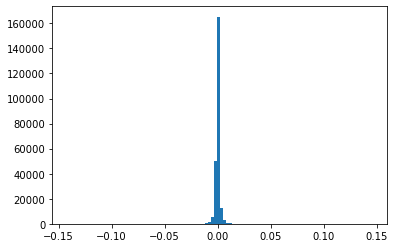

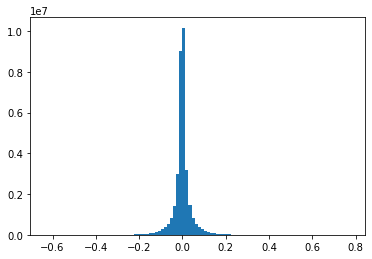

In [32]:
# Linear
c = 18
w_lin = np.linalg.lstsq(X_shuf_train[:, 20-c:], y_shuf_train, rcond=None)[0]
y_pred_lin = (X_shuf_val[:, 20-c:] @ w_lin)
residuals = y_shuf_val - y_pred_lin

plt.hist(residuals, bins=100)
plt.show()

plt.hist(amp_data, bins=100)
plt.show()

/tmp/ipykernel_120718/2925386342.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y_predicted = X_shuf_val[:,-C1:] @ np.linalg.lstsq(X_shuf_val[:,-C1:], y_shuf_val)[0]


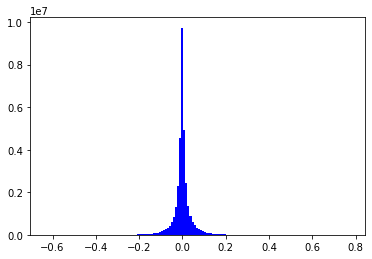

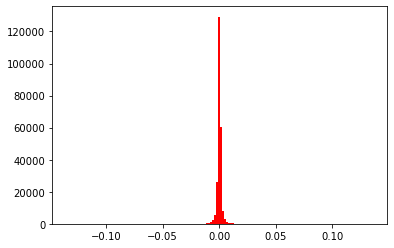

In [33]:
C1 = 18
y_predicted = X_shuf_val[:,-C1:] @ np.linalg.lstsq(X_shuf_val[:,-C1:], y_shuf_val)[0]
val_mse = (y_shuf_val - y_predicted)


plt.hist(amp_data, bins=150, color='b')
plt.show()
plt.hist(val_mse, bins=150, color='r')
plt.show()

In [ ]:
make_vv(10,4).T

In [ ]:
make_vv_ben(10,4)


In [ ]:
C =5
t = np.arange(0,C)*(1/20)+1-C/20
t

In [ ]:
np.array([t**i for i in range(K)]).T

In [ ]:
np.linspace(0.95 - ((C-1)*0.05), 0.95, C)

In [ ]:

make_vv_ben(10,3)

In [ ]:


np.arange(0,1,1/10)

In [ ]:
def mean_sq_err(C, K, N, X, y):
    v = make_vv(C, K)
    y_pred = v.T @ X[:N,20-C:].T
    y_pred_err = y - y_pred
    y_pred_err_sq = y_pred_err**2

    return y_pred_err_sq.mean()

print(f"Train MSE: {mean_sq_err(14, 4, len(y_shuf_train), X_shuf_train, y_shuf_train)}")
print(f"Validation MSE: {mean_sq_err(14, 4, len(y_shuf_val), X_shuf_val, y_shuf_val)}")
print(f"Test MSE: {mean_sq_err(14, 4, len(y_shuf_test), X_shuf_test, y_shuf_test)}")